In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [3]:
# Data Preparation
df = pd.read_csv('/kaggle/input/daigt_external_dataset.csv')
df['combined_text'] = df['text'].combine_first(df['source_text'])
df['label'] = df['text'].notna().astype(int)

In [4]:
# Tokenization & Dataset preparation
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_length = 256  # Adjust this based on your dataset

In [5]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        inputs = tokenizer.encode_plus(text, 
                                       add_special_tokens=True, 
                                       max_length=max_length, 
                                       padding='max_length', 
                                       truncation=True, 
                                       return_tensors='pt')
        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()
        return input_ids, attention_mask, label

In [7]:
# Split the indices of the dataframe
indices = torch.randperm(len(df)).tolist()
train_indices = indices[:train_size]
val_indices = indices[train_size:]

train_df = df.iloc[train_indices]
val_df = df.iloc[val_indices]

train_dataset = TextDataset(train_df['combined_text'].tolist(), train_df['label'].tolist())
val_dataset = TextDataset(val_df['combined_text'].tolist(), val_df['label'].tolist())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [8]:
# Model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Loss & Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * 3)

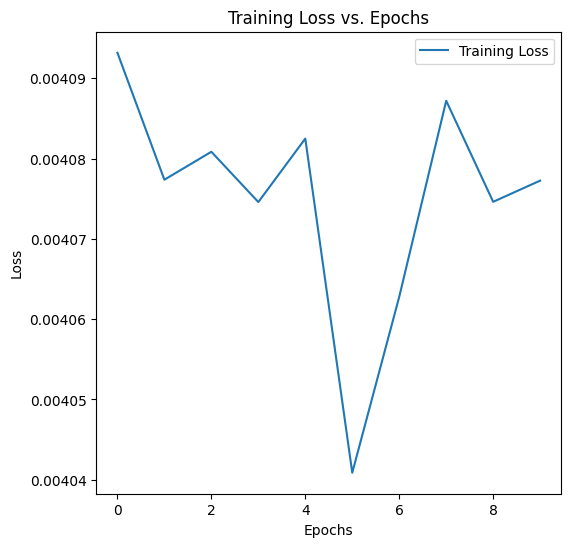

In [19]:
# Training loop
training_losses = []
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for input_ids, attention_mask, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        input_ids, attention_mask, labels = input_ids.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')), attention_mask.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')), labels.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')).float()
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask).logits.squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
        
    avg_loss = total_loss / len(train_loader)
    training_losses.append(avg_loss)

    # Print the epoch loss first
    print(f"Epoch {epoch+1}, Loss: {avg_loss}")
    
    # Clear the previous plot
    clear_output(wait=True)
    
    # Plotting the current losses
    plt.figure(figsize=(6, 6))
    plt.plot(training_losses, label="Training Loss")
    plt.title("Training Loss vs. Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [20]:
# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for input_ids, attention_mask, labels in val_loader:
        input_ids, attention_mask, labels = input_ids.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')), attention_mask.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')), labels.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')).float()
        outputs = model(input_ids, attention_mask=attention_mask).logits.squeeze(1)
        rounded_preds = torch.round(torch.sigmoid(outputs))
        correct += (rounded_preds == labels).sum().item()
        total += len(labels)

print(f"Accuracy: {correct / total}")

Accuracy: 1.0
